<a href="https://colab.research.google.com/github/sayakpaul/SimCLR-in-TensorFlow-2/blob/master/10_Per_Fine_tune_Imagenet_Subset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
!nvidia-smi

Thu Aug 20 04:36:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Restoring model weights from GCS Bucket

In [3]:
!wget https://storage.googleapis.com/resnet-simclr-pseudo-labels/resnet_simclr_modified_ae.h5

--2020-08-20 04:36:53--  https://storage.googleapis.com/resnet-simclr-pseudo-labels/resnet_simclr_modified_ae.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96848264 (92M) [application/octet-stream]
Saving to: ‘resnet_simclr_modified_ae.h5’

resnet_simclr_modif 100%[===================>]  92.36M   153MB/s    in 0.6s    

2020-08-20 04:36:54 (153 MB/s) - ‘resnet_simclr_modified_ae.h5’ saved [96848264/96848264]



In [2]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset gathering and preparation

In [ ]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

In [3]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [4]:
# 10% of the dataset
train_images_10 = np.random.choice(train_images, len(train_images)//10)
len(train_images_10)

125

In [5]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [6]:
X_train, y_train = prepare_images(train_images_10)
X_test, y_test = prepare_images(test_images)

  7%|▋         | 17/250 [00:00<00:01, 164.19it/s]

(125, 224, 224, 3) (125,)


100%|██████████| 250/250 [00:01<00:00, 228.07it/s]


(250, 224, 224, 3) (250,)


In [7]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## Utilities

In [8]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainabe = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [9]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights('resnet_simclr_modified_ae.h5')
resnet_simclr.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)              

In [10]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [11]:
# Encoder model with no projection
extractor = Model(resnet_simclr.input, resnet_simclr.layers[-6].output) # weights are already loaded

def get_training_model(trainable=False):
    inputs = Input(shape=(224, 224, 3))
    extractor.trainable = trainable
    x = extractor(inputs, training=False)
    x = Dense(5, activation="softmax")(x)
    classifier = Model(inputs=inputs, outputs=x)
    
    return classifier

In [12]:
model = get_training_model()
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
functional_3 (Functional)    (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


## Warmup

In [13]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

Epoch 1/35
2/2 [==============================] - 2s 1s/step - loss: 1.9744 - accuracy: 0.2720 - val_loss: 2.0067 - val_accuracy: 0.3160
Epoch 2/35
2/2 [==============================] - 1s 339ms/step - loss: 1.7825 - accuracy: 0.3200 - val_loss: 1.6630 - val_accuracy: 0.2840
Epoch 3/35
2/2 [==============================] - 1s 332ms/step - loss: 1.5205 - accuracy: 0.3760 - val_loss: 1.5425 - val_accuracy: 0.3400
Epoch 4/35
2/2 [==============================] - 1s 344ms/step - loss: 1.3671 - accuracy: 0.4400 - val_loss: 1.5177 - val_accuracy: 0.3840
Epoch 5/35
2/2 [==============================] - 1s 272ms/step - loss: 1.3747 - accuracy: 0.4720 - val_loss: 1.5951 - val_accuracy: 0.3840
Epoch 6/35
2/2 [==============================] - 1s 336ms/step - loss: 1.3365 - accuracy: 0.4880 - val_loss: 1.4952 - val_accuracy: 0.4400
Epoch 7/35
2/2 [==============================] - 1s 337ms/step - loss: 1.2060 - accuracy: 0.5280 - val_loss: 1.4568 - val_accuracy: 0.4080
Epoch 8/35
2/2 [=======

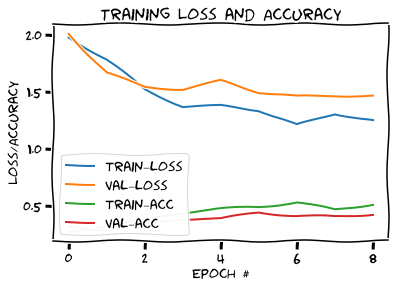

In [14]:
model = get_training_model()

model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer='adam')

history = model.fit(X_train, y_train_enc,
                 validation_data=(X_test, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

## Fine-tune

Epoch 1/35
2/2 [==============================] - 2s 1s/step - loss: 1.2994 - accuracy: 0.4560 - val_loss: 1.3432 - val_accuracy: 0.4280
Epoch 2/35
2/2 [==============================] - 1s 475ms/step - loss: 1.1110 - accuracy: 0.5680 - val_loss: 1.2964 - val_accuracy: 0.4480
Epoch 3/35
2/2 [==============================] - 1s 479ms/step - loss: 1.0120 - accuracy: 0.6320 - val_loss: 1.2809 - val_accuracy: 0.4600
Epoch 4/35
2/2 [==============================] - 1s 475ms/step - loss: 0.9221 - accuracy: 0.6720 - val_loss: 1.2724 - val_accuracy: 0.4560
Epoch 5/35
2/2 [==============================] - 1s 459ms/step - loss: 0.8746 - accuracy: 0.6880 - val_loss: 1.2629 - val_accuracy: 0.4640
Epoch 6/35
2/2 [==============================] - 1s 461ms/step - loss: 0.7984 - accuracy: 0.7120 - val_loss: 1.2552 - val_accuracy: 0.4600
Epoch 7/35
2/2 [==============================] - 1s 465ms/step - loss: 0.7702 - accuracy: 0.7440 - val_loss: 1.2487 - val_accuracy: 0.4600
Epoch 8/35
2/2 [=======

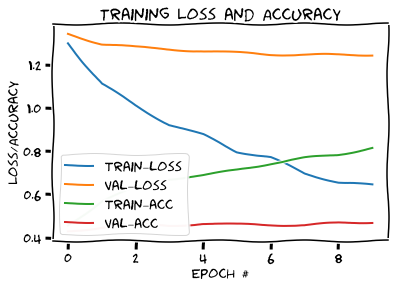

In [15]:
model.layers[1].trainable = True

model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer=tf.keras.optimizers.Adam(1e-5)) # Low learning rate

history = model.fit(X_train, y_train_enc,
                 validation_data=(X_test, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)